[View in Colaboratory](https://colab.research.google.com/github/roman807/TGS_Salt/blob/master/unet_10_13_9pm.ipynb)

Unet: train model and evaluate results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras import optimizers
from keras import backend as K
from sklearn.metrics import confusion_matrix, log_loss
from google.colab import files
import tensorflow as tf
import cv2
import os
import json
import zipfile
import skimage.io as io
import skimage.transform as trans
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import h5py

Using TensorFlow backend.


In [2]:
##### Use kaggle API
!pip install kaggle
api_token = {"username":"romanm87","key":"daa9da19c31bf091978760ad6eb373f3"}
os.chdir('/')
!mkdir ~/.kaggle #kaggle API searches in root directory for .kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
# API link from Kaggle:
!kaggle competitions download -c tgs-salt-identification-challenge
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall()
zip_ref.close()

    100% |████████████████████████████████| 61kB 1.8MB/s 
    100% |████████████████████████████████| 235kB 5.9MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 60.9MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 76.5MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 61.1MB/s]
 93% 152M/163M [00:01<00:00, 111MB/s] 
100% 163M/163M [00:01<00:00, 111MB/s]
 45% 17.0M/37.9M [00:00<00:00, 69.0MB/s]
100% 37.9M/37.9M [00:00<00:00, 132MB/s] 


In [0]:
##### Prepare data
tr_image_dir = os.chdir('/images')
train_im = os.listdir(tr_image_dir)
x = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in train_im]) / 255
tr_masks_dir = os.chdir('/masks')
train_ma = os.listdir(tr_masks_dir)
y = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in train_ma]) / 255
# expand dimensions for CNN
x = np.expand_dims(x, axis=3)
y = np.expand_dims(y, axis=3)
# split training vs validation set
train_val_split = 0.1
x_train = x[0:int(x.shape[0]*(1-train_val_split)),:,:,:]
y_train = y[0:int(y.shape[0]*(1-train_val_split)),:,:,:]
x_val = x[int(x.shape[0]*(1-train_val_split)):,:,:,:]
y_val = y[int(y.shape[0]*(1-train_val_split)):,:,:,:]

In [0]:
##### define model

def unet(pretrained_weights = None, input_size=(101,101,1)):
    inputs = Input(input_size)
    input_padded = ZeroPadding2D(padding=((14, 13), (14, 13)))(inputs)  ## use zero padding to match dims after maxpool/upsample
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_padded)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv4)#(drop4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    pool5 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv5)
    conv5b = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool5)
    conv5b = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5b)
    conv5b = Conv2D(1024, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv5b)
    conv5b = Conv2D(1024, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv5b)
    up5b = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv5b))
    merge6 = merge([conv5,up5b], mode='concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = merge([conv4,up6], mode='concat', concat_axis = 3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = merge([conv3,up7], mode='concat', concat_axis = 3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode='concat', concat_axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode='concat', concat_axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    crop = Cropping2D(cropping=((14, 13), (14, 13)))(conv10)
    model = Model(inputs=inputs, output=crop)
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model
  
# def unet(pretrained_weights = None, input_size=(101,101,1), ks=kernel_size):
#     inputs = Input(input_size)
#     input_padded = ZeroPadding2D(padding=((14, 13), (14, 13)))(inputs)  ## use zero padding to match dims after maxpool/upsample
#     conv1 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(input_padded)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
#     conv1 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv1)
#     conv2 = Conv2D(128, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
#     conv2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv2)
#     conv3 = Conv2D(256, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
#     conv3 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv3)
#     conv4 = Conv2D(512, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
#     conv4 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv4)#(drop4)
#     conv5 = Conv2D(1024, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
#     conv5 = Conv2D(1024, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
#     up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv5))
#     merge6 = merge([conv4,up6], mode='concat', concat_axis = 3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
#     up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
#     merge7 = merge([conv3,up7], mode='concat', concat_axis = 3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
#     up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = merge([conv2,up8], mode='concat', concat_axis=3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
#     up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = merge([conv1,up9], mode='concat', concat_axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
#     crop = Cropping2D(cropping=((14, 13), (14, 13)))(conv10)
#     model = Model(inputs=inputs, output=crop)
#     if(pretrained_weights):
#     	model.load_weights(pretrained_weights)
#     return model


In [0]:
##### Define evaluation metrics [NOT IN USE]
# class MeanIoU(object):
#     def __init__(self):
#         super().__init__()
#     def mean_iou(self, y_true, y_pred):
#         # Wraps np_mean_iou method and uses it as a TensorFlow op.
#         # Takes numpy arrays as its arguments and returns numpy arrays as outputs
#         return tf.py_func(self.np_mean_iou, [y_true, y_pred], tf.float64)
#     def np_mean_iou(self, y_true, y_pred):
#         y_pred = np.round(y_pred + 0.05, 0).reshape(-1)
#         y_true = y_true.reshape(-1)        
#         conf = confusion_matrix(y_pred, y_true)        
#         # Compute the IoU and mean IoU from the confusion matrix:
#         true_positive = conf[1,1]
#         false_positive = conf[1,0]
#         false_negative = conf[0,1]
#         # Just in case we get a division by 0, ignore/hide the error and set the value to 0
#         with np.errstate(divide='ignore', invalid='ignore'):
#             iou = true_positive / (true_positive + false_positive + false_negative)
#         #iou[np.isnan(iou)] = 0
#         return np.mean(iou).astype(np.float64)
# miou = MeanIoU()
# def bin_acc05(y_true, y_pred):
#     return K.mean(K.equal(y_true, K.round(y_pred + 0.05)), axis=-1)

In [5]:
##### Define model 

# # sgd (decay learning rate by 10 over all training steps)
# n_epochs = 20
# batch_size = 100
# n_steps = (3600 / batch_size) * n_epochs
# total_decay = 0.001
# decay = 1 - total_decay ** (1 / n_steps)

model = unet()
adam = optimizers.Adam(lr = 1e-4)   # best run 1e-4 // defaul: 1e-3
#sgd = optimizers.SGD(lr=0.1, momentum=0.99, decay=decay, nesterov=False)
model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarni

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [6]:
##### Run model
filepath = 'weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_val,y_val), callbacks=callbacks_list, verbose=1)

Train on 3600 samples, validate on 400 samples
Epoch 1/25
3600/3600 [==============================] - 89s 25ms/step - loss: 0.5945 - acc: 0.7508 - val_loss: 0.5354 - val_acc: 0.7628

Epoch 00001: val_acc improved from -inf to 0.76284, saving model to weights.best.hdf5
Epoch 2/25
3600/3600 [==============================] - 74s 20ms/step - loss: 0.5226 - acc: 0.7508 - val_loss: 0.4989 - val_acc: 0.7628

Epoch 00002: val_acc did not improve from 0.76284
Epoch 3/25
3600/3600 [==============================] - 74s 20ms/step - loss: 0.4334 - acc: 0.7693 - val_loss: 0.3664 - val_acc: 0.8557

Epoch 00003: val_acc improved from 0.76284 to 0.85567, saving model to weights.best.hdf5
Epoch 4/25
3600/3600 [==============================] - 74s 20ms/step - loss: 0.3705 - acc: 0.8551 - val_loss: 0.3210 - val_acc: 0.8788

Epoch 00004: val_acc improved from 0.85567 to 0.87884, saving model to weights.best.hdf5
Epoch 5/25
3600/3600 [==============================] - 74s 21ms/step - loss: 0.3188 - acc:

In [0]:
##### load best weights:

model.load_weights('weights.best.hdf5')

In [8]:
##### Predict results
y_train_pred = model.predict(x_train, verbose=1)
y_val_pred = model.predict(x_val, verbose=1)

400/400 [==============================] - 3s 7ms/step


In [0]:
print(y_val_pred.min())
print(y_val_pred.shape)

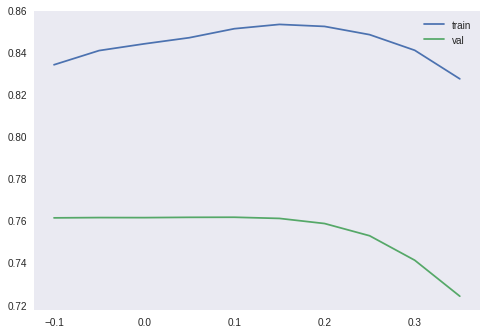

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


mean IOU training: 0.8470229981309897
mean IOU validation: 0.76159119072345
loss training: nan
loss validation: nan


In [9]:
### Evaluate results:
y_train = y_train.reshape(-1)[:(400*101*101)]
y_train_pred = y_train_pred.reshape(-1)[:(400*101*101)]
y_val = y_val.reshape(-1)
y_val_pred = y_val_pred.reshape(-1)

true_positive_train = []
false_positive_train = []
false_negative_train = []
iou_train = []
true_positive_val = []
false_positive_val = []
false_negative_val = []
iou_val = []
thresh = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
for i in thresh:
    y_train_pred_bin = np.round(y_train_pred + i, 0)
    y_val_pred_bin = np.round(y_val_pred + i, 0)
    conf_train = confusion_matrix(y_train_pred_bin, y_train)
    true_positive_train.append(conf_train[1,1])
    false_positive_train.append(conf_train[1,0])
    false_negative_train.append(conf_train[0,1])
    iou_train.append(conf_train[1,1]/(conf_train[1,1]+conf_train[1,0]+conf_train[0,1]))
    conf_val = confusion_matrix(y_val_pred_bin, y_val)
    true_positive_val.append(conf_val[1,1])
    false_positive_val.append(conf_val[1,0])
    false_negative_val.append(conf_val[0,1])
    iou_val.append(conf_val[1,1]/(conf_val[1,1]+conf_val[1,0]+conf_val[0,1]))
d = {'true_positive_train': true_positive_train, 'false_positive_train':  \
     false_positive_train, 'false_negative_train': false_negative_train, \
     'iou_train': iou_train, 'true_positive_val': true_positive_val, 'false_positive_val':  \
     false_positive_val, 'false_negative_val': false_negative_val, 'iou_val': iou_val, }
df = pd.DataFrame.from_dict(d, orient='index')
df.columns = ['-0.1', '-0.05', '0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35']
plt.plot(thresh, iou_train) 
plt.plot(thresh, iou_val)
plt.legend(['train', 'val'])
plt.grid()
plt.show()

i = 0.05 # <- lower threshold for positive predictions (i.e: i=0.1 --> threshold=0.4)
y_train_pred_bin = np.round(y_train_pred + i, 0)
y_val_pred_bin = np.round(y_val_pred + i, 0)
loss_train = log_loss(y_train, y_train_pred)
loss_val = log_loss(y_val, y_val_pred)               
print('mean IOU training: ' + str(iou_train[3]))
print('mean IOU validation: ' + str(iou_val[3]))
print('loss training: ' + str(loss_train))
print('loss validation: ' + str(loss_val))

In [0]:
###### Download results to local computer for evaluation [NOT IN USE]
# from google.colab import files
# results_train = pd.DataFrame({'y_train': y_train.reshape(-1)[:(400*101*101)],'y_train_pred': \
#                               y_train_pred.reshape(-1)[:(400*101*101)]})
# results_train.to_csv("results_train.csv")
# results_val = pd.DataFrame({'y_val': y_val.reshape(-1),'y_val_pred': y_val_pred.reshape(-1)})
# results_val.to_csv('results_val.csv')
# files.download('results_train.csv')
# files.download('results_val.csv')

In [13]:
y_val_pred.mean()

0.23033868

In [11]:
##### save model and weights
# https://stackoverflow.com/questions/48924165/google-colaboratory-weight-download-export-saved-models
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# 2. Save Keras Model or weights on google drive
# create on Colab directory
model.save('model_3322.h5')    
model_file = drive.CreateFile({'title' : 'model_3322.h5'})
model_file.SetContentFile('model_3322.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})
model.save_weights('model_weights_3322.h5')
weights_file = drive.CreateFile({'title' : 'model_weights_3322.h5'})
weights_file.SetContentFile('model_weights_3322.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

GoogleDriveFile({'id': '12cqpOyyqEEl30jGmcjEVoARfDcB9bicC'})

In [26]:
y_train_pred[50:100]

array([0.00503684, 0.00538168, 0.00586951, 0.00647025, 0.00719448,
       0.0079073 , 0.00856224, 0.0091567 , 0.00967239, 0.01021167,
       0.01074237, 0.0112762 , 0.01181257, 0.01234576, 0.01286832,
       0.01336894, 0.01377307, 0.01406397, 0.01426635, 0.01450133,
       0.01483444, 0.01526764, 0.01578286, 0.01636514, 0.01702736,
       0.01774496, 0.01859898, 0.01970528, 0.02104622, 0.02275222,
       0.02472558, 0.02707887, 0.02984645, 0.03322568, 0.03719867,
       0.04203765, 0.04655034, 0.05003434, 0.05184649, 0.05240975,
       0.05280109, 0.05290642, 0.05327027, 0.05395169, 0.05453774,
       0.05469927, 0.05456806, 0.05541839, 0.05564683, 0.05594668],
      dtype=float32)